### Test123

In [41]:
import pandas as pd
import numpy as np
import time
import os
from flair.models import TextClassifier
from flair.data import Sentence
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import re
from emoji import demojize
from tabulate import tabulate
import matplotlib.pyplot as plt

# Load Flair model once globally
print("Loading Flair model...")
start_time = time.time()
model_name = 'sentiment-en-mix-distilbert'
cache_dir = os.path.expanduser('~/.flair/models')
os.makedirs(cache_dir, exist_ok=True)
local_model_path = os.path.join(cache_dir, 'sentiment-en-mix-distillbert_4.pt')

try:
    classifier = TextClassifier.load(model_name)
except FileNotFoundError as e:
    print(f"Failed to load model automatically: {e}")
    if os.path.exists(local_model_path):
        print(f"Attempting to load from local path: {local_model_path}")
        classifier = TextClassifier.load(local_model_path)
    else:
        print("Model not found locally. Please download it manually from:")
        print("https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt")
        print(f"And place it in {cache_dir}")
        raise

classifier.to('cpu')
print(f"Model loaded in {time.time() - start_time:.2f} seconds.")

Loading Flair model...
Failed to load model automatically: [Errno 2] No such file or directory: 'sentiment-en-mix-distilbert'
Attempting to load from local path: C:\Users\duckh/.flair/models\sentiment-en-mix-distillbert_4.pt
Model loaded in 1.55 seconds.


In [42]:
import flair
print(f"Flair cache root: {flair.cache_root}")

Flair cache root: C:\Users\duckh\.flair


In [43]:
usecols = ['comment_id', 'comment_text', 'comment_author', 'comment_time', 'comment_score', 
           'match_time', 'matchday', 'home_team', 'away_team', 'winner']
dtypes = {'comment_id': 'str', 'comment_score': 'float32', 'matchday': 'int8'}
df = pd.read_csv('comments_data.csv', usecols=usecols, dtype=dtypes)
df['comment_score'] = pd.to_numeric(df['comment_score'], errors='coerce').fillna(0).astype('int32')

In [44]:
print("Inspecting comment_score column:")
print(df['comment_score'].head(10))  # Show first 10 values
print("Data type:", df['comment_score'].dtype)
print("Number of non-numeric values (NaN):", df['comment_score'].isna().sum())
print("Unique values in comment_score:", df['comment_score'].unique()[:20])  # Show first 20 unique values

# Convert comment_score to int32 after loading
df['comment_score'] = pd.to_numeric(df['comment_score'], errors='coerce').astype('int32', errors='ignore')
print(f"Loaded dataset with {len(df)} rows in {time.time() - start_time:.2f} seconds.")

Inspecting comment_score column:
0     1
1     3
2    10
3     7
4     1
5     3
6     1
7     6
8     1
9    -2
Name: comment_score, dtype: int32
Data type: int32
Number of non-numeric values (NaN): 0
Unique values in comment_score: [  1   3  10   7   6  -2   5  -1   0   2   4   9  11  -6 -10 117  50   8
  -3  53]
Loaded dataset with 186304 rows in 2.14 seconds.


In [ ]:
custom_emote_map = {r':-\)': 'positive_smile', r':\)': 'positive_smile', 
                    r':-\(': 'negative_frown', r':\(': 'negative_frown', 
                    r'>\:\(': 'negative_angry'
}

def preprocess_emotes_vectorized(comments, use_demojize = False):
    comments = comments.fillna('').str.replace('|'.join(map(re.escape, custom_emote_map.keys())), 
                                              lambda m: custom_emote_map[m.group()], regex=True)
    if use_demojize:
        comments = np.vectorize(demojize)(comments)  # Convert all emojis to text descriptions
    else:
        emoji_map = {'😊': 'positive_smile', '😞': 'negative_frown'}  # Limited custom mapping
        for emoji, desc in emoji_map.items():
            comments = comments.str.replace(emoji, desc)
    return comments

# Sentiment analysis with balanced rules
negative_slang = {'trash', 'garbage', 'shit', 'awful'}
positive_keywords = {'good', 'brilliant', 'amazing', 'great', 'fantastic', 'awesome', 'super'}
def batch_sentiment(df_chunk, batch_size=1000, neutral_threshold=0.5):
    if isinstance(df_chunk, pd.DataFrame) and 'processed_text' in df_chunk.columns:
        texts = df_chunk['processed_text']
    elif isinstance(df_chunk, pd.Series):
        texts = df_chunk
    elif isinstance(df_chunk, str):
        texts = pd.Series([df_chunk])
    else:
        raise ValueError("Input must be a DataFrame with 'processed_text' column, a Series, or a string")
    
    valid_texts = texts[(texts.notna()) & (texts != '[deleted]') & (texts.str.strip() != '')]
    if len(valid_texts) == 0:
        return pd.Series([None] * len(texts), index=texts.index), pd.Series([None] * len(texts), index=texts.index)
    
    sentences = [Sentence(text) for text in valid_texts]
    if not sentences:
        return pd.Series([None] * len(texts), index=texts.index), pd.Series([None] * len(texts), index=texts.index)
    
    try:
        classifier.predict(sentences, mini_batch_size=32)
    except Exception as e:
        print(f"Prediction error: {e}")
        return pd.Series([None] * len(texts), index=texts.index), pd.Series([None] * len(texts), index=texts.index)
    
    sentiments = pd.Series([None] * len(texts), index=texts.index)
    scores = pd.Series([None] * len(texts), index=texts.index)
    
    for idx, sent in zip(valid_texts.index, sentences):
        if not sent.labels:
            print(f"No labels assigned for text at index {idx}: '{texts[idx]}'")
            continue
        label = sent.labels[0]
        score = label.score
        sentiment = label.value
        text_lower = texts[idx].lower()
        if score < neutral_threshold:
            sentiment = "NEUTRAL"
        elif sentiment == "POSITIVE":
            negative_count = sum(1 for slang in negative_slang if slang in text_lower)
            if negative_count > 1:
                sentiment = "NEGATIVE"
        elif sentiment == "NEGATIVE":
            if any(kw in text_lower for kw in positive_keywords):
                sentiment = "POSITIVE"
        sentiments[idx] = sentiment
        scores[idx] = score
    
    return sentiments, scores

print("Processing without demojize...")
df['processed_text'] = preprocess_emotes_vectorized(df['comment_text'], use_demojize=False)
start_time = time.time()
batch_size = 5000
batches = [df[i:i + batch_size] for i in range(0, len(df), batch_size)]
results = []
with tqdm(total=len(batches), desc="Processing sentiment") as pbar:
    for batch in batches:
        sentiments, scores = batch_sentiment(batch)
        batch_result = batch.copy()
        batch_result['sentiment'] = sentiments
        batch_result['confidence'] = scores
        results.append(batch_result)
        pbar.update(1)
results_df_no_demojize = pd.concat(results, ignore_index=True)
print(f"Sentiment analysis (no demojize) completed in {time.time() - start_time:.2f} seconds.")
print("Sentiment Distribution (no demojize):")
print(results_df_no_demojize['sentiment'].value_counts())

print("\nProcessing with demojize...")
df['processed_text'] = preprocess_emotes_vectorized(df['comment_text'], use_demojize=True)
start_time = time.time()
results = []
with tqdm(total=len(batches), desc="Processing sentiment") as pbar:
    for batch in batches:
        sentiments, scores = batch_sentiment(batch)
        batch_result = batch.copy()
        batch_result['sentiment'] = sentiments
        batch_result['confidence'] = scores
        results.append(batch_result)
        pbar.update(1)
results_df_with_demojize = pd.concat(results, ignore_index=True)
print(f"Sentiment analysis (with demojize) completed in {time.time() - start_time:.2f} seconds.")
print("Sentiment Distribution (with demojize):")
print(results_df_with_demojize['sentiment'].value_counts())

Processing without demojize...


Processing sentiment: 100%|██████████| 38/38 [17:32<00:00, 27.70s/it]


Sentiment analysis (no demojize) completed in 1052.58 seconds.
Sentiment Distribution (no demojize):
sentiment
NEGATIVE    110678
POSITIVE     73286
Name: count, dtype: int64

Processing with demojize...


Processing sentiment: 100%|██████████| 38/38 [17:40<00:00, 27.91s/it]

Sentiment analysis (with demojize) completed in 1060.80 seconds.
Sentiment Distribution (with demojize):
sentiment
NEGATIVE    110678
POSITIVE     73286
Name: count, dtype: int64


In [46]:
team_keywords = {
    'Arsenal': r'(arsenal|afc|gooners)',
    'Aston Villa': r'(aston villa|villa|avfc)',
    'Bournemouth': r'(bournemouth|afcb|cherries)',
    'Brentford': r'(brentford|bfc|bees)',
    'Brighton & Hove Albion': r'(brighton|bha|seagulls)',
    'Chelsea': r'(chelsea|cfc|blues)',
    'Crystal Palace': r'(crystal palace|palace|cpfc)',
    'Everton': r'(everton|efc|toffees)',
    'Fulham': r'(fulham|ffc|cottagers)',
    'Ipswich Town': r'(ipswich|itfc|tractor boys)',
    'Leicester City': r'(leicester|lcfc|foxes)',
    'Liverpool': r'(liverpool|lfc|reds)',
    'Manchester City': r'(manchester city|city|mcfc)',
    'Manchester United': r'(manchester united|united|man utd|mufc)',
    'Newcastle United': r'(newcastle|nufc|magpies)',
    'Nottingham Forest': r'(nottingham forest|forest|nffc)',
    'Southampton': r'(southampton|saints|sfc)',
    'Tottenham Hotspur': r'(tottenham|spurs|thfc)',
    'West Ham United': r'(west ham|whu|hammers)',
    'Wolverhampton Wanderers': r'(wolves|wwfc|wanderers)'
}
team_pattern = '|'.join(f'({pattern})' for pattern in team_keywords.values())
def detect_teams_vectorized(comments, home_team, away_team):
    comments = comments.fillna('').str.lower()
    home_team = home_team.str.lower()
    away_team = away_team.str.lower()
    
    teams = []
    for c, h, a in zip(comments, home_team, away_team):
        mentioned = set()
        if h in c or h[:4] in c:
            mentioned.add(h.title())
        if a in c or a[:4] in c:
            mentioned.add(a.title())
        matches = re.finditer(team_pattern, c)
        for match in matches:
            for team, pattern in team_keywords.items():
                if re.search(pattern, c):
                    mentioned.add(team)
        teams.append(list(mentioned) if mentioned else [None])
    return teams

# Apply team detection
print("Detecting teams...")
start_time = time.time()
results_df['teams_mentioned'] = detect_teams_vectorized(results_df['processed_text'], results_df['home_team'], results_df['away_team'])
results_exploded = results_df.explode('teams_mentioned')
print(f"Team detection completed in {time.time() - start_time:.2f} seconds.")


# Time preprocessing
print("Performing time-based preprocessing...")
start_time = time.time()
results_exploded['comment_datetime'] = pd.to_datetime(results_exploded['comment_time'], unit='s')
results_exploded['match_datetime'] = pd.to_datetime(results_exploded['match_time'], errors='coerce')
results_exploded['time_diff'] = (results_exploded['comment_datetime'] - results_exploded['match_datetime']).dt.total_seconds() / 60
print(f"Time preprocessing completed in {time.time() - start_time:.2f} seconds.")

# Define analyze_new_sentence
def analyze_new_sentence(text):
    processed_text = preprocess_emotes_vectorized(pd.Series([text]))[0]
    sentiments, scores = batch_sentiment(processed_text)  # Pass processed_text as a string
    sentiment, score = sentiments[0], scores[0]
    print(f"\nAnalysis of new sentence: '{text}'")
    print(f"Processed text: '{processed_text}'")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {score:.4f}" if score is not None else "Confidence: N/A")
    return sentiment, score


Detecting teams...
Team detection completed in 9.17 seconds.
Performing time-based preprocessing...
Time preprocessing completed in 0.09 seconds.


In [47]:
def analyze_by_team(df):
    print("\nSentiment by Team (Top 10 Mentioned):")
    team_sentiment = df.groupby('teams_mentioned')['sentiment'].value_counts().unstack(fill_value=0)
    top_teams = team_sentiment.sum(axis=1).nlargest(10).index
    team_sentiment = team_sentiment.loc[top_teams].reset_index()
    print(tabulate(team_sentiment, headers='keys', tablefmt='grid', showindex=False))

    team_sentiment_plot = team_sentiment.set_index('teams_mentioned')
    team_sentiment_plot.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title('Sentiment Distribution by Top 10 Teams')
    plt.xlabel('Team')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

def analyze_by_matchday(df):
    print("\nSentiment by Matchday:")
    matchday_sentiment = df.groupby('matchday')['sentiment'].value_counts().unstack(fill_value=0).reset_index()
    print(tabulate(matchday_sentiment, headers='keys', tablefmt='grid', showindex=False))

    matchday_sentiment_plot = matchday_sentiment.set_index('matchday')
    matchday_sentiment_plot.plot(kind='bar', figsize=(10, 6), colormap='plasma')
    plt.title('Sentiment Distribution by Matchday')
    plt.xlabel('Matchday')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

def analyze_temporal_trends(df):
    print("\nSentiment by Time Since Match Start (15-min intervals):")
    df['time_bin'] = pd.cut(df['time_diff'], bins=range(0, 121, 15), right=False)
    time_sentiment = df.groupby('time_bin')['sentiment'].value_counts().unstack(fill_value=0).reset_index()
    print(tabulate(time_sentiment, headers='keys', tablefmt='grid', showindex=False))

    time_sentiment_plot = time_sentiment.set_index('time_bin')
    time_sentiment_plot.plot(kind='bar', figsize=(10, 6), colormap='magma')
    plt.title('Sentiment Distribution by Time Since Match Start')
    plt.xlabel('Time Bin (minutes)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

def analyze_winner_effect(df):
    print("\nSentiment by Match Winner:")
    winner_sentiment = df.groupby('winner')['sentiment'].value_counts().unstack(fill_value=0).reset_index()
    print(tabulate(winner_sentiment, headers='keys', tablefmt='grid', showindex=False))

    winner_sentiment_plot = winner_sentiment.set_index('winner')
    winner_sentiment_plot.plot(kind='bar', figsize=(10, 6), colormap='inferno')
    plt.title('Sentiment Distribution by Match Winner')
    plt.xlabel('Winner')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

def analyze_by_scenarios(df):
    print("\nSentiment Distribution by Scenarios:")

    # Scenario 1: Goal Proximity
    goal_times = [15, 30, 60, 75, 90]
    goal_window = 5
    df['near_goal'] = df['time_diff'].apply(lambda x: any(abs(x - gt) <= goal_window for gt in goal_times))
    print("\nScenario 1: Comments Near Likely Goal Times (within 5 minutes):")
    goal_sentiment = df[df['near_goal'] == True]['sentiment'].value_counts().reindex(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], fill_value=0).reset_index()
    goal_sentiment.columns = ['Sentiment', 'Count']
    print(tabulate(goal_sentiment, headers='keys', tablefmt='grid', showindex=False))

    plt.figure(figsize=(6, 6))
    plt.pie(goal_sentiment['Count'], labels=goal_sentiment['Sentiment'], autopct='%1.1f%%', colors=['green', 'red', 'gray'])
    plt.title('Sentiment Distribution Near Goal Times')
    plt.show()

    # Scenario 2: Halftime
    df['is_halftime'] = df['time_diff'].between(45, 60)
    print("\nScenario 2: Comments During Halftime (45-60 minutes):")
    halftime_sentiment = df[df['is_halftime'] == True]['sentiment'].value_counts().reindex(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], fill_value=0).reset_index()
    halftime_sentiment.columns = ['Sentiment', 'Count']
    print(tabulate(halftime_sentiment, headers='keys', tablefmt='grid', showindex=False))

    plt.figure(figsize=(6, 6))
    plt.pie(halftime_sentiment['Count'], labels=halftime_sentiment['Sentiment'], autopct='%1.1f%%', colors=['green', 'red', 'gray'])
    plt.title('Sentiment Distribution During Halftime')
    plt.show()

Overall Sentiment Distribution:
+-------------+---------+
| Sentiment   |   Count |
+=============+=========+
| NEGATIVE    |  117871 |
+-------------+---------+
| POSITIVE    |   64567 |
+-------------+---------+
| NEUTRAL     |    7510 |
+-------------+---------+


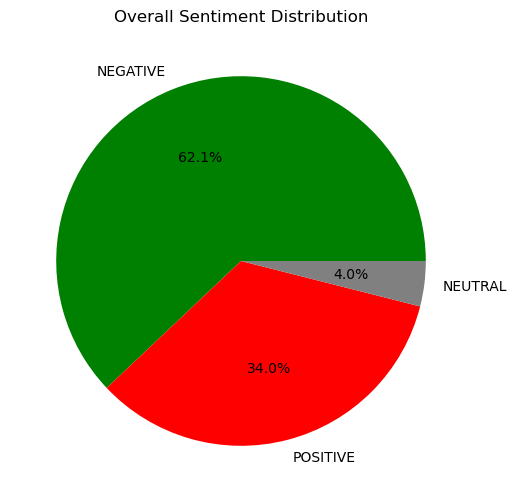


Sentiment by Team (Top 10 Mentioned):
+------------------------+------------+-----------+------------+
| teams_mentioned        |   NEGATIVE |   NEUTRAL |   POSITIVE |
+========================+============+===========+============+
| Arsenal                |       4117 |       311 |       2113 |
+------------------------+------------+-----------+------------+
| Manchester City        |       3809 |       299 |       1964 |
+------------------------+------------+-----------+------------+
| Manchester United      |       2866 |       219 |       1493 |
+------------------------+------------+-----------+------------+
| Liverpool              |       2773 |       206 |       1525 |
+------------------------+------------+-----------+------------+
| Tottenham Hotspur      |       2072 |       185 |       1267 |
+------------------------+------------+-----------+------------+
| Chelsea                |       2016 |       147 |       1072 |
+------------------------+------------+-----------+

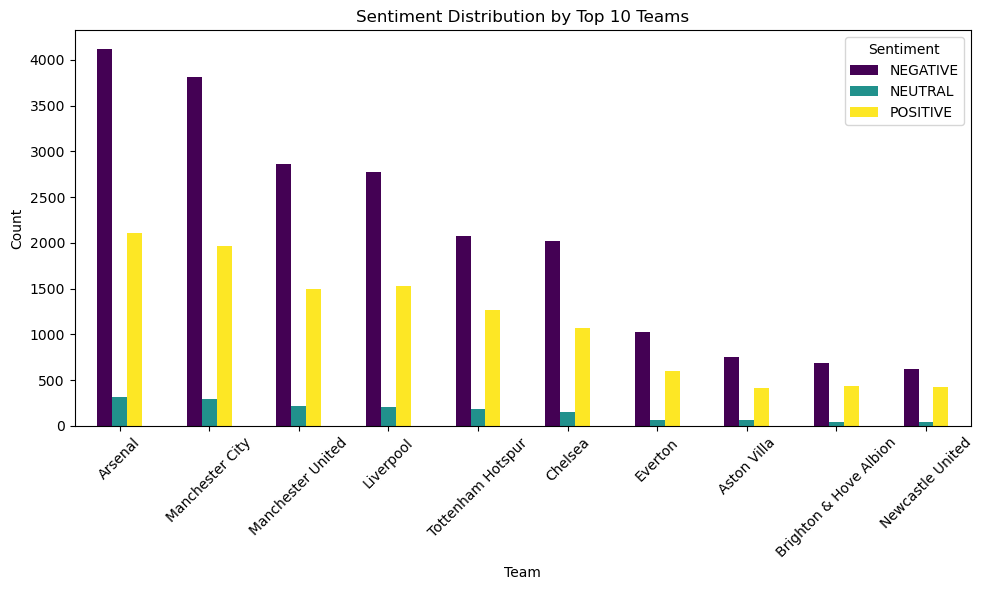


Sentiment by Matchday:
+------------+------------+-----------+------------+
|   matchday |   NEGATIVE |   NEUTRAL |   POSITIVE |
+============+============+===========+============+
|          1 |       9953 |       636 |       5263 |
+------------+------------+-----------+------------+
|          2 |       5629 |       391 |       3477 |
+------------+------------+-----------+------------+
|          3 |       3845 |       239 |       2095 |
+------------+------------+-----------+------------+
|          4 |       6549 |       390 |       3336 |
+------------+------------+-----------+------------+
|          5 |       9864 |       545 |       5027 |
+------------+------------+-----------+------------+
|          6 |       8099 |       524 |       4400 |
+------------+------------+-----------+------------+
|          7 |       5378 |       325 |       2755 |
+------------+------------+-----------+------------+
|          8 |       7289 |       453 |       3682 |
+------------+--------

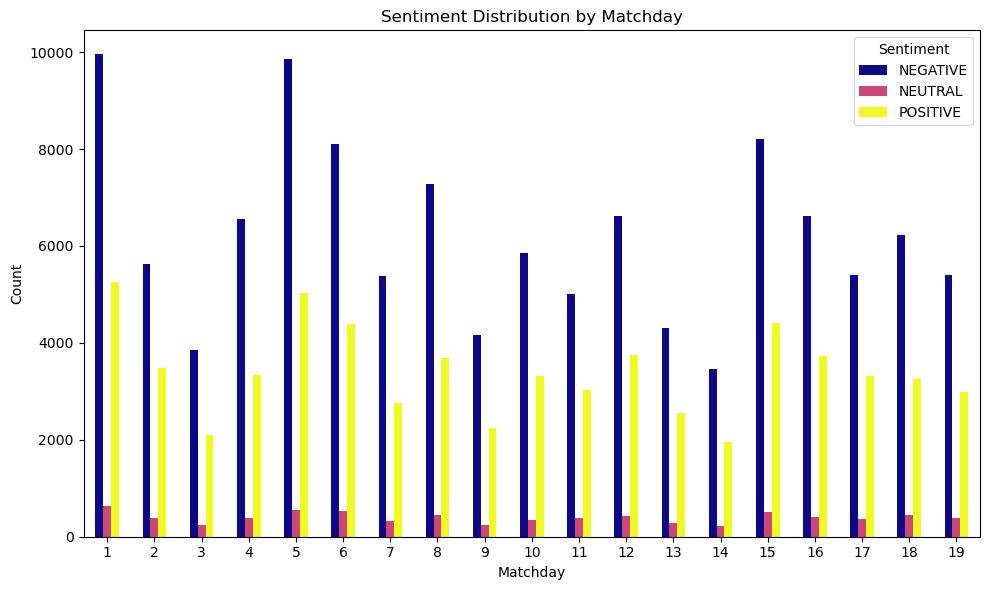


Sentiment by Time Since Match Start (15-min intervals):
+------------+------------+-----------+------------+
| time_bin   |   NEGATIVE |   NEUTRAL |   POSITIVE |
+============+============+===========+============+
| [0, 15)    |       6925 |       494 |       4247 |
+------------+------------+-----------+------------+
| [15, 30)   |      13867 |       877 |       7696 |
+------------+------------+-----------+------------+
| [30, 45)   |      17772 |      1100 |       8938 |
+------------+------------+-----------+------------+
| [45, 60)   |      13715 |       781 |       6640 |
+------------+------------+-----------+------------+
| [60, 75)   |       9403 |       573 |       4763 |
+------------+------------+-----------+------------+
| [75, 90)   |      16046 |      1041 |       8867 |
+------------+------------+-----------+------------+
| [90, 105)  |      17050 |      1104 |       9593 |
+------------+------------+-----------+------------+
| [105, 120) |      16431 |      1096 |   

C:\Users\duckh\AppData\Local\Temp\ipykernel_59764\2509505883.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_sentiment = df.groupby('time_bin')['sentiment'].value_counts().unstack(fill_value=0).reset_index()


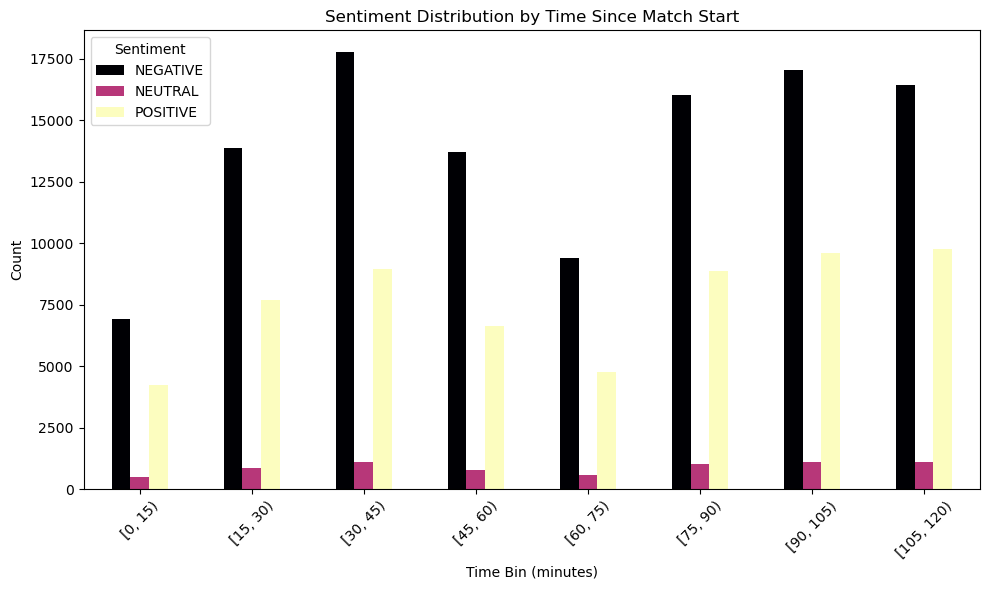


Sentiment by Match Winner:
+----------------------------+------------+-----------+------------+
| winner                     |   NEGATIVE |   NEUTRAL |   POSITIVE |
+============================+============+===========+============+
| AFC Bournemouth            |       3114 |       196 |       1798 |
+----------------------------+------------+-----------+------------+
| Arsenal FC                 |      12160 |       798 |       6759 |
+----------------------------+------------+-----------+------------+
| Aston Villa FC             |       2185 |       148 |       1442 |
+----------------------------+------------+-----------+------------+
| Brentford FC               |        618 |        27 |        289 |
+----------------------------+------------+-----------+------------+
| Brighton & Hove Albion FC  |       2739 |       198 |       1731 |
+----------------------------+------------+-----------+------------+
| Chelsea FC                 |       8680 |       554 |       5025 |
+-----

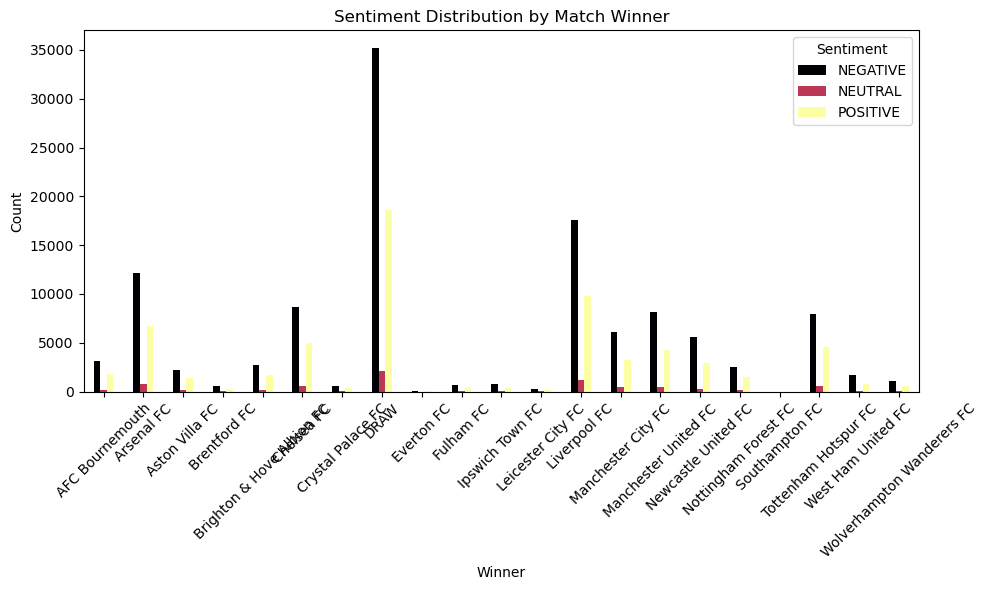


Sentiment Distribution by Scenarios:

Scenario 1: Comments Near Likely Goal Times (within 5 minutes):
+-------------+---------+
| Sentiment   |   Count |
+=============+=========+
| POSITIVE    |   24014 |
+-------------+---------+
| NEGATIVE    |   44854 |
+-------------+---------+
| NEUTRAL     |    2861 |
+-------------+---------+


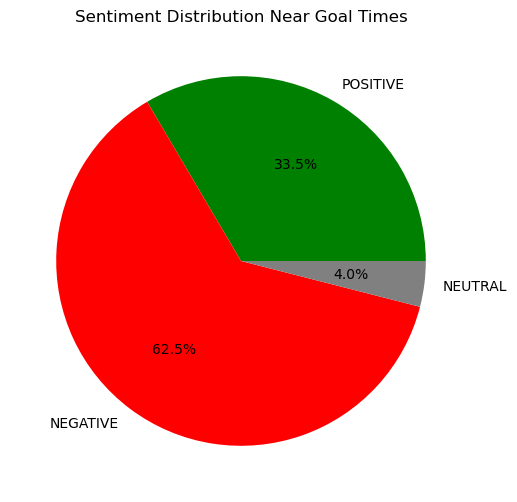


Scenario 2: Comments During Halftime (45-60 minutes):
+-------------+---------+
| Sentiment   |   Count |
+=============+=========+
| POSITIVE    |    6643 |
+-------------+---------+
| NEGATIVE    |   13724 |
+-------------+---------+
| NEUTRAL     |     781 |
+-------------+---------+


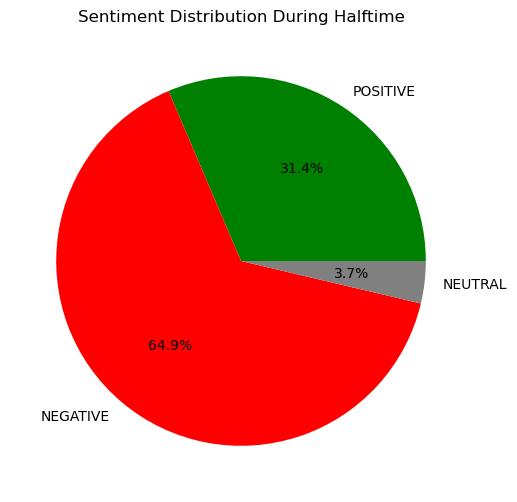

In [48]:
# Execute analysis
print("Overall Sentiment Distribution:")
overall_sentiment = results_exploded['sentiment'].value_counts().reset_index()
overall_sentiment.columns = ['Sentiment', 'Count']
print(tabulate(overall_sentiment, headers='keys', tablefmt='grid', showindex=False))

plt.figure(figsize=(6, 6))
plt.pie(overall_sentiment['Count'], labels=overall_sentiment['Sentiment'], autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title('Overall Sentiment Distribution')
plt.show()

analyze_by_team(results_exploded)
analyze_by_matchday(results_exploded)
analyze_temporal_trends(results_exploded)
analyze_winner_effect(results_exploded)
analyze_by_scenarios(results_exploded)

In [ ]:
def analyze_new_sentence(text, use_demojize = False):
    processed_text = preprocess_emotes_vectorized(pd.Series([text]), use_demojize = use_demojize)[0]
    sentiments, scores = batch_sentiment(processed_text)
    sentiment, score = sentiments[0], scores[0]
    print(f"\nAnalysis of new sentence: '{text}'")
    print(f"Processed text: '{processed_text}'")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {score:.4f}" if score is not None else "Confidence: N/A")
    return sentiment, score

# Testing

In [73]:
# Analyze a new sentence
new_sentence = "sick goal"
analyze_new_sentence(new_sentence)


Analysis of new sentence: 'sick goal'
Processed text: 'sick goal'
Sentiment: NEGATIVE
Confidence: 0.9972


('NEGATIVE', 0.9971828460693359)